# Controlling Glucose Metabolism in Yeast
(Based on a final project submitted by Seth Woodbury to BIOEN 599, March, 2024, University of Washington)

# Preliminaries

In [3]:
from controlSBML import ControlSBML

import numpy as np

In [4]:
TIMES = np.linspace(0, 10, 100)

# 1. Problem Description & Control Objectives

**IMPORTANT LINKS:**

<u>Selected Biomodel:</u> Nishio2008 - Design of the phosphotransferase system for enhanced glucose uptake in E. coli

<u>Biomodel URL:</u> https://www.ebi.ac.uk/biomodels/BIOMD0000000571

<u>Publication URL:</u> https://www.embopress.org/doi/full/10.1038/msb4100201

**PROBLEM DESCRIPTION:**

Industrial bioreactors culturing engineered microbes present a cost-effective, highly efficient, minimal-resource cost, and eco-friendly method of producing large quantities of desirable proteins and complex organic compounds for societal use (e.g., academia, therapeutics, industrial chemistry, biotechnology sectors). The biological problem I am addressing regards controlling Escherichia coli (E. coli) glucose uptake for such industrial microbe engineering purposes since they are the most well-studied and commonly used microbe. From a bioreactor production standpoint, it is desirable to have E. coli uptake as much glucose as possible for the ultimate production of ATP and the desired plasmid product(s) they were engineered to produce (i.e., protein products or protein machinery to make small organic molecules). However, E. coli have evolved to highly regulate their glucose uptake for the optimal cooperative survival and proliferation of their colonies; if they sense low glucose in the environment, they will try to use other carbon sources and metabolites for energy and they will shift toward conservative/catabolic metabolic processes rather than the anabolic ones we want them to perform. Ideally, we want E. coli in a bioreactor to initially divide to a certain concentration, then we want to induce them to grow as fat as possible (taking in the maximal possible glucose as fuel) to become full of our intended product before we lyse them all to harvest our product.

E. coli have evolved a complex phosphotransferase system that acts in a biological circuit to control the transfer of glucose into the cell while simultaneously phosphorylating it. The specific biological problem that I will be engineering in this system is how to control and enhance the concentration of ``phosphorylated EI`` or ``EI_P`` from the gene ptsI. The phosphotransfer of the phosphate on phosphoenolpyruvate to EI making EI_P is the first step in the phosphotransferase cascade system that ultimately phosphorylates glucose and transports it into the cell. This reaction is also thought to be the rate-limiting step in glucose intake so aiming to control and upregulate EI_P concentration will push equilibrium towards a higher glucose intake.

**CONTROL OBJECTIVES:**

In the given model, the extracellular glucose concentration is held constant which could mimic a bioreactor that is continuously feeding E. coli glucose while they divide and grow before their plasmid expression is induced. At t = 500 minutes in the model the glucose levels drop instantaneously by several orders of magnitude to cause a perturbation (see below). As a reminder, we want to resist ``EI_P`` decrease at all costs and ideally minimize its increase from the reverse of the phosphotransferase cascade since the last step depends partially on glucose concentration and each phosphate transfer is reversible. **Thus, our control objectives are:**
* Keep the ``EI_P`` concentration in the range above 2.4e-7M at all costs but ideally [2.4e-7 M, 4.0e-7 M] for at least 720 minutes (12 hours).
* Minimize any potential concentration oscillations and keep the oscillations within the concentration range above.
* Converge to a stable, steady-state system after the glucose decrease at t = 500 minutes within 120 minutes (t = 620 minutes).
* With each additional step this setting time should also be within t = 30 minutes & the final ``EI_P`` should steady out.

Achieving these control objectives will allow our engineered E. coli to keep maximally uptaking glucose even after we shut down its continuous flow into the bioreactor. Keeping the ``EI_P`` range above 2.4e-7 M is significant because this is its steady-state concentration at glucose concentrations that are magnitudes higher at t < 500 minutes, so maintaining an ``EI_P`` this high after t = 500 minutes will mean the E. coli are still uptaking glucose at a similar rate as before. Keeping it below 3.4e-7 M is a good sign that the rest of the phosphotransferase cascade is not backing up or slowing down significantly. Cells enjoy homeostasis and consistency, so minimizing ``EI_P`` oscillations will be important to not throw off other equilibriums that are not necessarily modeled here with respect to glucose uptake, we want a continuous flux of glucose coming in that keeps our E. coli busy at making proteins. Finally, 30 minutes is a pretty short time for E. coli so it would be desirable if the system could converge within 30 minutes so the E. coli are not thrown out of homeostasis.

## Antimony Model

In [5]:
# Assign file URL to a variable
TIMES = np.linspace(000, 1500, 5000)
BIOMODEL_SOURCE_FILE_URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1501300000/3/BIOMD0000000571_url.xml"

# Create tellurium SBML model & print the antimony
CTLSB = ControlSBML(BIOMODEL_SOURCE_FILE_URL, xlabel="time (min)", times=TIMES)
ANTIMONY_MODEL_EI_P = CTLSB.getAntimony()
print(ANTIMONY_MODEL_EI_P)

// Created by libAntimony v2.13.2
model *MODEL1501300000()

  // Compartments and Species:
  compartment cyt;
  species CRP in cyt, CRPsiteI_crp in cyt, CRPsiteII_crp in cyt, CRPsite_cyaA in cyt;
  species CRPsite_genome in cyt, CRPsite_ptsGp1 in cyt, CRPsite_ptsGp2 in cyt;
  species CRPsite_ptsHp0 in cyt, CRPsite_ptsHp1 in cyt, CRPsite_ptsIp0 in cyt;
  species CRPsite_ptsIp1 in cyt, CRPsite_mlcp1 in cyt, CRPsite_mlcp2 in cyt;
  species Mlc in cyt, Mlcsite_mlcp1 in cyt, Mlcsite_mlcp2 in cyt, Mlcsite_ptsGp1 in cyt;
  species Mlcsite_ptsGp2 in cyt, Mlcsite_ptsHp0 in cyt, Mlcsite_ptsIp0 in cyt;
  species CRP_cAMP in cyt, CRP_cAMP_CRPsiteI_crp in cyt, CRP_cAMP_CRPsiteII_crp in cyt;
  species CRP_cAMP_CRPsite_cyaA in cyt, CRP_cAMP_CRPsite_genome in cyt, CRP_cAMP_CRPsite_ptsGp1 in cyt;
  species CRP_cAMP_CRPsite_ptsGp2 in cyt, CRP_cAMP_CRPsite_ptsHp0 in cyt;
  species CRP_cAMP_CRPsite_ptsHp1 in cyt, CRP_cAMP_CRPsite_ptsIp0 in cyt;
  species CRP_cAMP_CRPsite_ptsIp1 in cyt, CRP_cAMP_CRPsite_ml

## Preliminary Investigation

We begin by plotting the time course of all species in the simulation. Because of the large number of species and the vastly differently scales of their units, this is not very insightful, as shown below.

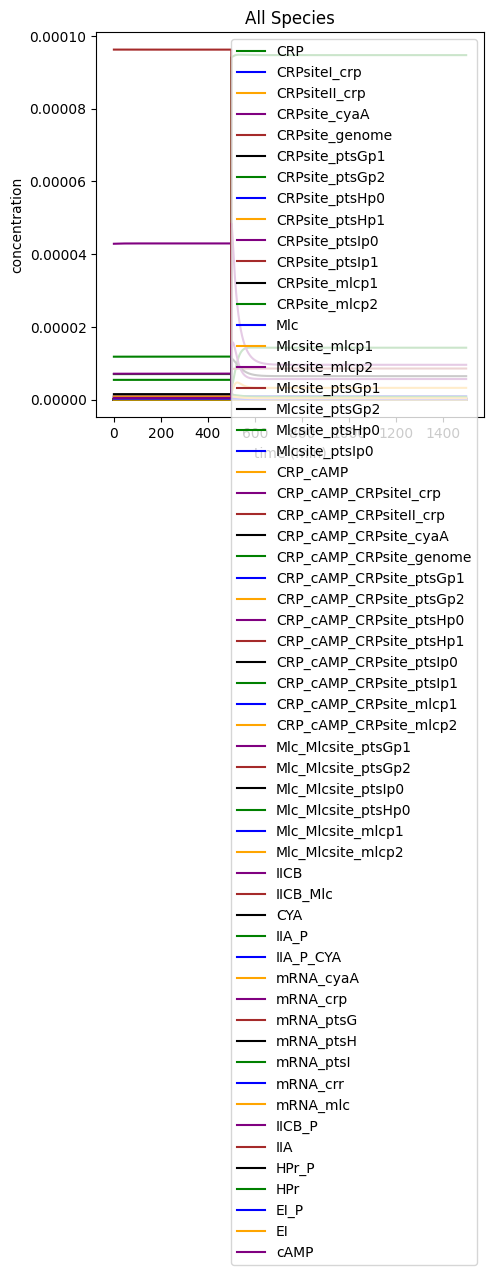

In [6]:
_ = CTLSB.plotModel(times=TIMES, legend=True, title="All Species")

We can see that at t = 500 the sudden change in glucose quickly perturbes the system but it seems to quickly return to homeostasis. There are a ton of things being modeled here so let's take a look at ``EI_P``:

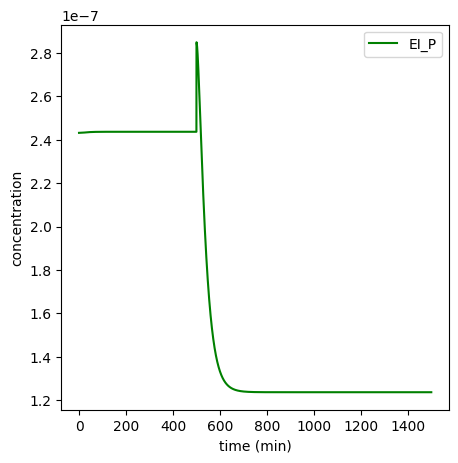

In [7]:
_ = CTLSB.plotModel(times=TIMES, selections=["EI_P"], legend=True)

There it is, the glucose drop at t = 500 minutes causes a rapid backup in the phosphotransferase cascade due to the last species not being able to recruit glucose so quickly due to mass action and therefore ``EI_P`` accumulates before the genetic circuit catches up and calls for less EI protein production.

# 2. System Definition

As mentioned, there are many outputs and boundaries in this model system. Some genetic or protein controls might be helpful. This evolved system already has 'accelerator' and 'decelerator' controls built into it, we are attempting to hijack those controls and essentially 'control the controls.' In practice, this could be something like amplifying certain genes in the E. coli DNA, adding new genes to their DNA, or deleting genes from their DNA. Based on the publication, here are some possible 'controls to control:'
* CRPsite_ptsIp1 or CRPsite_ptsIp0 (promoters or enhancer sites for EI gene)
* CRPsiteII_crp or CRPsiteI_crp (promoters or enhancer sites for sensor genes that upregulate 'acceleration')
* mRNA_ptsI (directly produces EI protein)
* mRNA_crp (directly produces sensor protein)
* Mlc or mRNA_mlc (downregulates phosphotransferase cascade & EI protein production)

Mlc seems like it could be an antagonist to the concentration of ``EI_P``. Note that I tried many different values for the time series to convert it to the right units, I tried across multiple orders of magnitude but nothing worked to detect the fluctuation at t = 500 minutes. For whatever reason it is giving a perturbation at t = 0 minutes so I thought that would be sufficient to view the relationships between different inputs and the output, like we see here. Now let us try a staircase: 

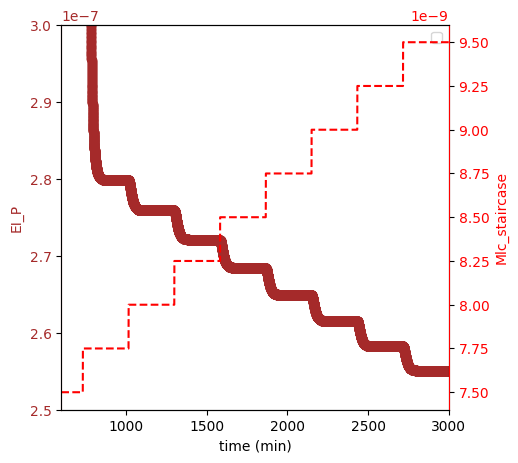

In [9]:
STAIRCASE_TIMES = np.linspace(450, 3000, 20000)
_ = CTLSB.plotStaircaseResponse(initial_value=7.5*1e-9, final_value=9.5*1e-9, num_step=8,
                                times=STAIRCASE_TIMES,
                                ylim=[2.5*1e-7, 3*1e-7],
                               xlim=[600, 3000])

Remember that we do not care about time points before 500 minutes because it is a steady-state, stable system with no interesting behavior because the glucose concentration is fixed. It is more interesting to see a rapid perturbation and the recovery to equilibrium, as this is most likely what E. coli will more realistically experience in a bioreactor - a shutoff of glucose supplement and the rapid decline of any glucose left in the solution with the E. coli.

Getting close! Let's increase our the end time to our goal, and while we're at it let's shoot for ~1220 minutes (12 hours after t = 500 min) the usual time E. coli will incubate after inducing plasmid expression (i.e., production of the desired product)!

This system with additional time resolution has successfully achieved reasonable control over the EIP output with the Mlc input. Furthermore, we successfully achieved the **following control objectives:**

* Kept the ``EI_P`` concentration in the range above 2.4e-7 M for over 720 minutes (12 hours) past t = 500 minutes. 
* Eliminated/minimized any potential concentration oscillations, although none were expected. 
* Converged to a stable, steady-state system after the glucose decreased within ~120 minutes before the staircase shift.
* With each additional step this setting time was drastically reduced to about ~30 minutes.

Ultimately, the final plot above achieves the control objectives by stabilizing as a nearly horizontal line within the desired setpoints after the initial glucose perturbation at t = 500 minutes. After the glucose perturbation, each step decrease in Mlc protein concentration increases the concentration of ``EI_P`` as expected since Mlc inhibits the production of EI protein. Thus, they are antagonistic. There are no oscillations about a setting point observed at any time which demonstrates that the second control objective was achieved. The third control objective can be noted at the time t = 575 minutes where the post-perturbation ``EI_P`` concentration stops growing and begins to drastically flatten out before the staircase decreases (plot above this one). Finally, the final control objective was achieved because the right tail is nearly horizontal and each step down on the staircase only increases the tail line for about 30 minutes before it becomes horizontal again.

Below, we provide the complete **revised system definition:**

1. SBML model: Nishio2008 - Design of the phosphotransferase system for enhanced glucose uptake in E. coli from Biomodels
1. Output: ``EI_P``
1. Input: ``Mlc``
1. Directional effect of the input on the output: Monotone ``EI_P`` decreases for stepwise ``Mlc`` increases
1. Operating region for the input: [8e-9 M, 9.5e-9 M]
1. Range of outputs that can be achieved [2.5e-7 M, 2.85e-7 M]

# 3. System Identification

System identification describes the system as a transfer function for the operating point specified in system definition. In our system, the input is ``Mlc`` and the output is ``EI_P``. ``Mlc`` is varied over the operating region of [7.6e-9, 8.0e-9]. The method ``plotTransferFunctionFit`` estimates to transfer function and plots the fit. It returns a Timeseries (a dataframe with the data plotted) and an AntimonyBuilder (the Antimony code run to produce the fitting data).

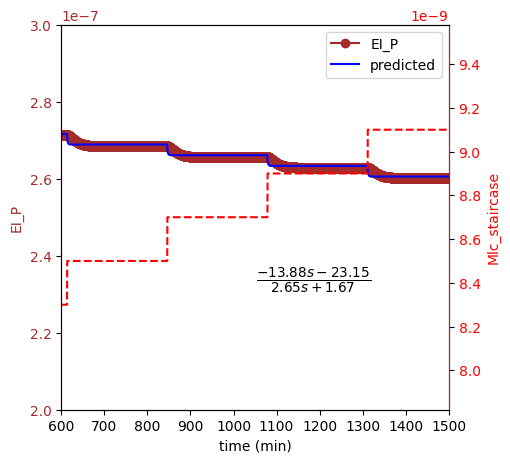

TransferFunction(array([-13.87916085, -23.15183568]), array([2.64794455, 1.66810054]))

In [10]:
_ = CTLSB.plotTransferFunctionFit(num_zero=1, num_pole=1, 
    initial_value=7.5*1e-9, final_value=9.5*1e-9, num_step=10,
                                times=STAIRCASE_TIMES,
                                ylim=[2*1e-7, 3*1e-7],
                                  fit_start_time=1000,
                               xlim=[600, 1500],
                                 fitter_method="gpz")

# Get the transfer function 
TRANSFER_FUNCTION = CTLSB.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

The fit is quite good, and it captures the inverse effect of Mlc on EI_P.

In [11]:
TRANSFER_FUNCTION.poles(), TRANSFER_FUNCTION.zeros()

(array([-0.62996052+0.j]), array([-1.66810054+0.j]))

# 4. Testbed Construction & Control Design

I will perform initial testbed construction with the ``plotClosedLoop`` function from the analysis of mTor since Professor Hellerstein had trouble loading my raw antimony file in HW1. This allows us to keep using CONTROL_SBML rather than loading in the antimony and pasting kP & kI in by hand.

#### kP, kI, & kP-kI Initial Guesses

100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.24s/it]


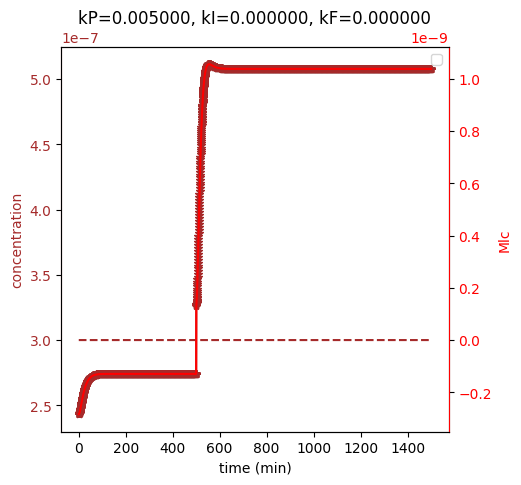

In [12]:
result = CTLSB.plotDesign(setpoint=0.0000003, kP_spec=0.005, times=TIMES, sign=1, markers=["*", "o", "+"])

Because of the inverse relationship between the input and output, the testbed is constructed with ``sign=1`` instead of the default setting of ``sign=-1``. We see that proportional control achieves a stable system as seen by the horizontal line that settles quickly after the perturbation, but we are way off our set point here with a simple guess for kP. Let us try I control:

In [14]:
result = CTLSB.plotDesign(setpoint=0.0000003, kP_spec=1, kI_spec=1, times=TIMES, sign=1)

100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.19s/it]

CVODE Error: CV_CONV_FAILURE: Convergence test failures occurred too many times (= MXNCF = 10) during one internal timestep or occurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)



/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** No design found!



This failed because the ``CVODE`` integrator could not solve the integration. This is a common symptom of an unstable system. So, we need to find different values of $k_P$ and $k_I$. We could do this manually. Instead, we use the ``ControlSBML`` grid search.

#### Iterative Exploration to Converge Toward a Satisfactory Control with PI Controller

Below, we make use of the grid search capabililtes of ControlSBML to find a good PI controller. We start from time 0 to capture the effect of a change in the glucose. ``plotDesign`` does a grid search of a space that has coordinates for the design parameters whose values are ``True``, which is indicated by the arguments ``kP_spec`` and ``kI_spec``. The range of values is specified by ``min_parameter_value`` and ``max_parameter_value``. The number of values for a design parameter is ``num_coordinate``.

 21%|██        | 21/100 [00:50<02:33,  1.95s/it]Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 19.9593 and h = 5.0291e-07, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 896.462 and h = 2.3838e-07, the error test failed repeatedly or with |h| = hmin.
 61%|██████    | 61/100 [01:43<00:54,  1.40s/it]Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 272.179 and h = 1.36316e-06, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 221.308 and h = 2.43855e-05, the error test failed repeatedly or with |h| = hmin.
 81%|████████  | 81/100 [02:08<00:25,  1.33s/it]Error: CVODE Error: CV_ERR_FAILURE, Module: CVODES, Function: CVode, Message: At t = 60.8647 and h = 5.80029e-07, the error test failed repeatedly or with |h| = hmin.
Error: CVODE Error: CV_

CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual double rr::CVODEIntegrator::integrate(double, double)
CVODE Error: CV_ERR_FAILURE: Error test failures occurred too many times (= MXNEF = 7) during one internal time step oroccurred with |h| = hmin.; In virtual

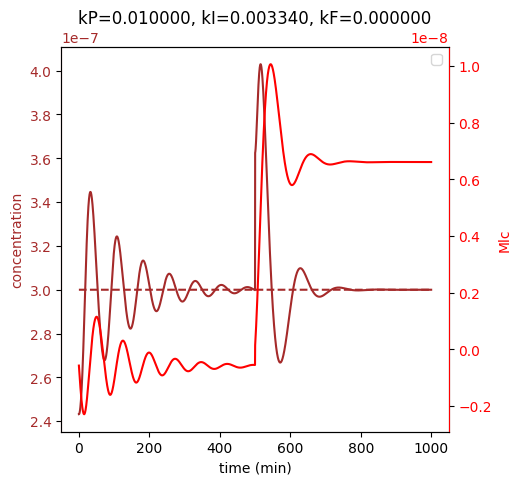

In [19]:
result = CTLSB.plotDesign(setpoint=0.0000003, kP_spec=True, kI_spec=True, num_coordinate=10, sign=1,
                          min_parameter_value=0.00001, max_parameter_value=0.01,
                          times=np.linspace(0, 1000, 10000))

This PI controller works beautifully for our system!! ``plotDesign`` returns an object that provides information about the designs that were explored and the results. The score is a positive number. A smaller score means that the design does a better job of regulating to the setpoint.

In [18]:
result.designs.dataframe

,score,kI,kP,reason
0,8.011309e-17,0.00334,0.01000,Design successful.
1,8.509836e-17,0.00334,0.00889,Design successful.
2,8.993214e-17,0.00223,0.01000,Design successful.
3,9.088444e-17,0.00334,0.00778,Design successful.
4,9.801483e-17,0.00334,0.00667,Design successful.
...,...,...,...,...
95,NaN,0.01000,0.00445,No design. Cannot simulate the closed loop sys...
96,NaN,0.00556,0.00223,No design. Cannot simulate the closed loop sys...
97,NaN,0.00778,0.00001,No design. Cannot simulate the closed loop sys...
98,NaN,0.00445,0.00889,No design. Cannot simulate the closed loop sys...


# 5. Discussion

One of the most initially confusing parts of control design to me was interpreting the root locus plots and trying to figure out why they were important/what information I could gather from them. I found it very helpful to rewatch some lectures/go through old notebooks that we did in the class, especially the root locus notebook. Additionally, I found it valuable to watch YouTube summaries about the root locus plots. In particular, this was an AMAZING video: https://www.youtube.com/watch?v=CRvVDoQJjYI

I found that the root locus plots contain a lot of extremely valuable information besides just stating if a system was stable and/or oscillating. Listening to the advice in the video about damping coefficients, settling times, and natural frequency was interesting and made me appreciate the power of a root locus plot.

An additional trouble that I had with control design was how to quantify the settling time. This is something that I could approximate by eye, but I could not figure out how to execute this in code. Perhaps it could be when the data is +/- 5% of the setpoing, but for how long? One oscillation? However, for everything else I found the workflow for closed loop design notebook to have an extremely logical and elegant grid searching algorithm/design pipeline that I decided to employ. It was very easy to manipulate its logic to add my score function, and it is a general method that I could keep adding more metrics for scoring. 

The notebooks in this class were very helpful for navigating this project in general, the analysis of mTor was a huge influence for me, and likewise so was the workflow for closed-loop design (+ everything else we did in class)! One thing in the future that would be excellent would be to have a compilation of all the functions, their inputs, and their outputs. I always would forget what inputs were possible for some of these functions, especially ones we do not see often so maybe we would only see the inputs once. It would be nice to know what the kwargs were and such so that I could manipulate my plots more and be better with how I use the data! Overall though, the notebooks were incredibly helpful.

Regarding this whole design pipeline, I think the most difficult step for me was the system identification because I couldn't find a directionally functional one. Thank you for being flexible with the final project and adapting it to accommodate it not being able to find an adequate transfer function for negative control. It was a really helpful and fun exercise for me to look through the ControlSBML github to find out a little bit more about how the fitting works and what the convergence logic looks like! This is where it would be slightly more helpful in the future to have some list of all the functions and their possible inputs because I would have loved to try messing around with more inputs to find out if I could change something that would have made it work better!

One of the biggest challenges in this project was finding a biomodel that was interesting/relevant to me but also had interesting behavior. This took a surprisingly long amount of time to find and many had poor variable names, strange behaviors, and other irregular features. In retrospect, I wish that I had picked a system that was a little simpler than this one because I could barely even make sense of the antimony here containing compartments and many other complex features that made it hard to physically understand what was being done to the system. However, I am glad that I stuck with it and ultimately I believe that I show a similar result to what was published: removing/minimizing Mlc protein (which was done by removing its gene) does result in more glucose intake! It is pretty satisfying to arrive at that conclusion and this has given me a brand new perspective and respect for systems biology, control engineering, and biomodeling. This is a powerful tool that makes me appreciate that adding or subtracting one thing from a system doesn't just change it proportionally, it perturbs a very complex equilibrium in ways that are hard to rationally predict sometimes because of the interconnectedness, interdependency, and redundancy in biology.

**In conclusion,** this was an eye-opening and very interesting class that is unlike anything I've taken before. I sincerely apologize for not being able to attend class in-person during some of the final weeks and for getting HW2 in late; I have had a lot of family issues happening this quarter and I had to fly home for the weekend HW2 was due when I missed your email. It's just been a stressful quarter with 4 classes and starting/trying to perform well in my new lab. I found this class to be very valuable and it has motivated me to take some classes in systems biology and more classes in biomodeling/biostatistics/computational biology. I hope there comes a time when I can apply this to my own research during graduate school, especially now that I've got a great pipeline to design & test simple controls. Thank you so much, Professor Hellerstein, I hope to see you around. Best of luck with your research & other classes!

P.S. I restarted my kernel on JupyterHub & ran all cells and verified that each one worked before submission per your advice from HW1. Please let me know if there is anything that doesn't work for you.